# Custom Images on pre-trained StyleGAN2

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.8 MB/s eta 0:0

In [2]:
# Import libraries
import os
import numpy as np
import glob

import torch
from torch_snippets import *

from PIL import Image

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Wed Apr 10 21:38:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

<center>
<table>
    <thead>
        <tr>
            <th style="text-align: center;">StyleGAN architecture</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>
                <img src="StyleGAN2.png" alt="StyleGAN2" height="500">
            </td>
        </tr>
    </tbody>
</table>
</center>

In [4]:
# Clone the pre-trained model's repository
if not os.path.exists('pytorch_stylegan_encoder'):
    !git clone https://github.com/sizhky/pytorch_stylegan_encoder.git
    %cd pytorch_stylegan_encoder
    !git submodule update --init --recursive
    !wget -q https://github.com/jacobhallberg/pytorch_stylegan_encoder/releases/download/v1.0/trained_models.zip
    !unzip -q trained_models.zip
    !rm trained_models.zip
    !mv trained_models/stylegan_ffhq.pth InterFaceGAN/models/pretrain
else:
    %cd pytorch_stylegan_encoder

# Import the required modules from the repository
from InterFaceGAN.models.stylegan_generator import StyleGANGenerator
from models.latent_optimizer import PostSynthesisProcessing

Cloning into 'pytorch_stylegan_encoder'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 367 (delta 2), reused 0 (delta 0), pack-reused 358
Receiving objects: 100% (367/367), 56.89 MiB | 15.88 MiB/s, done.
Resolving deltas: 100% (187/187), done.
/content/pytorch_stylegan_encoder
Submodule 'InterFaceGAN' (https://github.com/genforce/interfacegan) registered for path 'InterFaceGAN'
Cloning into '/content/pytorch_stylegan_encoder/InterFaceGAN'...
Submodule path 'InterFaceGAN': checked out 'b707e942187f464251f855c92f7009b8cf13bf03'


In [5]:
# Load the pre-trained model's generator, synthesis and mapping
synthesizer = StyleGANGenerator("stylegan_ffhq").model.synthesis
mapper = StyleGANGenerator("stylegan_ffhq").model.mapping
trunc = StyleGANGenerator("stylegan_ffhq").model.truncation

In [6]:
# Define a post-processing function for the generated images
post_processing = PostSynthesisProcessing()
post_process = lambda image: post_processing(image).detach().cpu().numpy().astype(np.uint8)[0]

# Create a function to convert a latent vector to an image
def latent2image(latent_vec):
    image = post_process(synthesizer(latent_vec))
    return image.transpose(1,2,0)

In [7]:
# Download a custom image and clone one more utility repository
!wget -q https://t4.ftcdn.net/jpg/02/32/98/33/360_F_232983351_z5CAl79bHkm6eMPSoG7FggQfsJLxiZjY.jpg -O my_image.jpg
!git clone https://github.com/sizhky/stylegan-encoder.git
!mkdir -p stylegan-encoder/raw_images
!mkdir -p stylegan-encoder/aligned_images
!mv my_image.jpg stylegan-encoder/raw_images

# Align the image
!python stylegan-encoder/align_images.py stylegan-encoder/raw_images/ stylegan-encoder/aligned_images/
!mv stylegan-encoder/aligned_images/* ./my_image.jpg

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 108, done.
remote: Total 108 (delta 0), reused 0 (delta 0), pack-reused 108
Receiving objects: 100% (108/108), 10.39 MiB | 6.19 MiB/s, done.
Resolving deltas: 100% (30/30), done.
2024-04-10 21:38:35.851464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 21:38:35.851527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 21:38:35.852945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 21:38:37.343851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorR

Optimizing Latents.
[2024-04-10 21:40:08,081][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2024-04-10 21:40:08,321][INFO] Successfully loaded!
[2024-04-10 21:40:08,321][INFO]   `lod` of the loaded model is 0.0.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 5

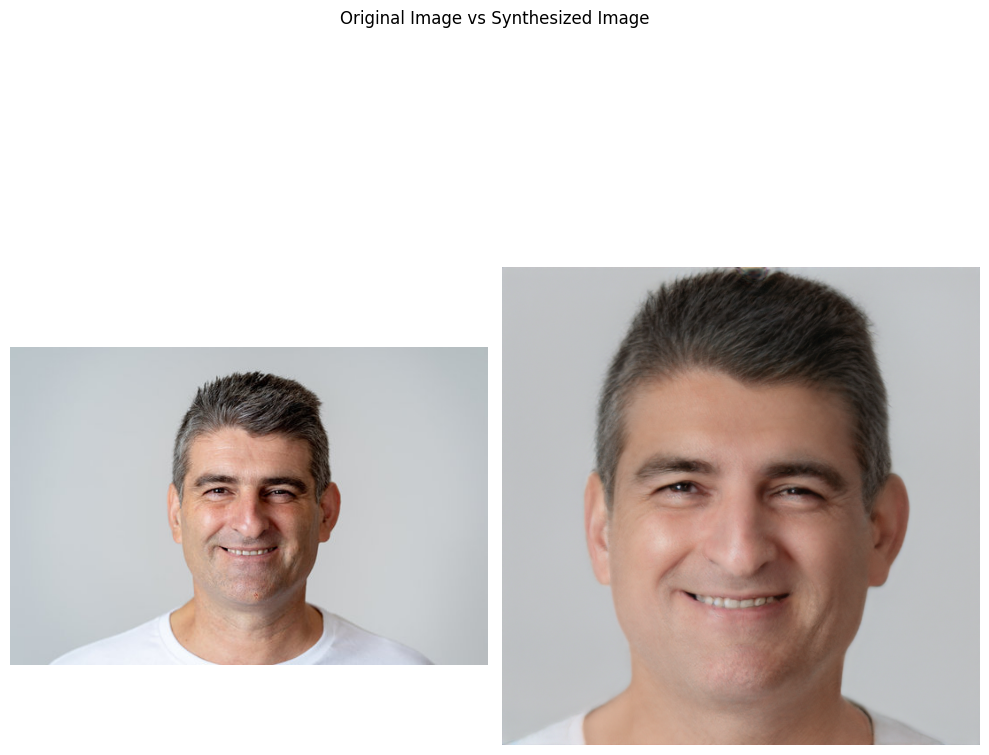

In [9]:
# Use the aligned image to generate a latent vector
custom_image = Image.open('/content/pytorch_stylegan_encoder/stylegan-encoder/raw_images/my_image.jpg')
!python encode_image.py ./my_image.jpg\
    pred_dlatents_my_image.npy\
    --use_latent_finder true\
    --image_to_latent_path ./trained_models/image_to_latent.pt

# Load the generated latent vector and convert it to an image
pred_dlatents = np.load('pred_dlatents_my_image.npy')
pred_dlatent = torch.from_numpy(pred_dlatents).float().cuda()
pred_image = latent2image(pred_dlatent)

# Display both the original and synthesized images
subplots([custom_image, pred_image], nc=2, suptitle='Original Image vs Synthesized Image', sz=10)

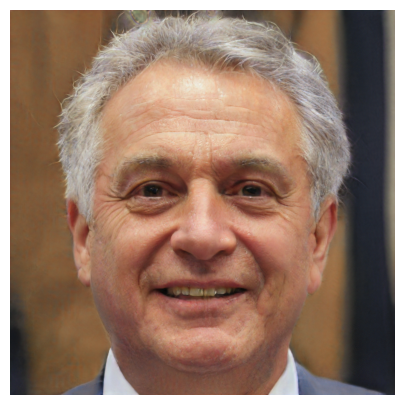

In [13]:
# Generate a random latent vector (1 x 512)
rand_latents = torch.randn(1, 512).cuda()

# Display the generated image from the random latent vector
show(latent2image(trunc(mapper(rand_latents))), sz=5)

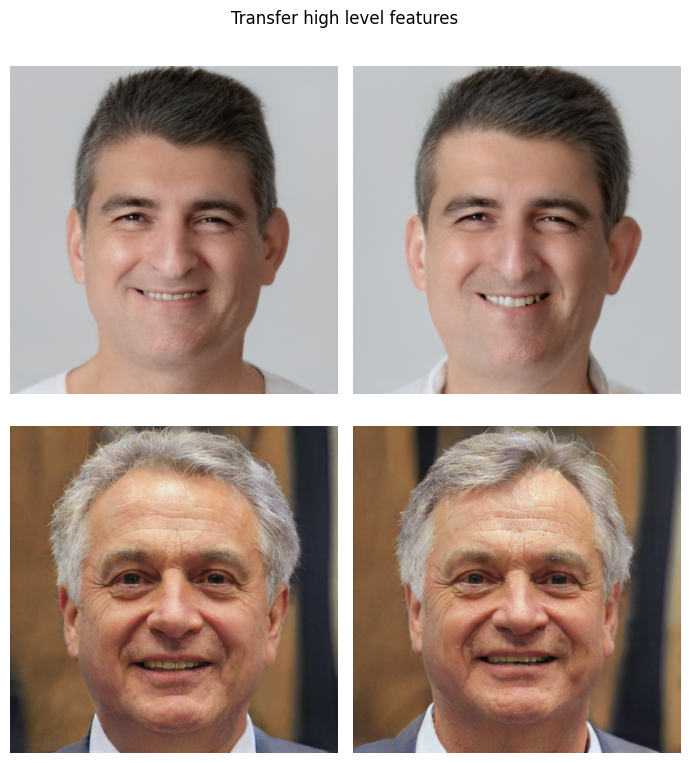

In [14]:
# Select indices for high-level feature transfer (first 3 features)
idxs_to_swap = slice(0, 3)

# Load the latent vector representing the custom image
custom_latents = torch.Tensor(np.load('pred_dlatents_my_image.npy', allow_pickle=True))

# Generate images from the custom latent vector and a randomly generated latent vector
custom_image = latent2image(custom_latents.cuda())
random_image = latent2image(trunc(mapper(rand_latents)))

# Prepare the latent vector for the generated image to swap high-level features
generated_image_latents = trunc(mapper(rand_latents))

# Clone the custom image's latent vector
custom_image_latents = custom_latents.clone()

# Replace the specified high-level features in the custom latent vector with those from the generated image's latent vector
custom_image_latents[:, idxs_to_swap] = generated_image_latents[:, idxs_to_swap]

# Generate an image from the modified latent vector to visualize the effect of swapping high-level features
swaped_custom_image = latent2image(custom_image_latents.float().cuda())

# Clone the generated image's latent vector to swap in the opposite direction
random_image_latents = generated_image_latents.clone()

# Replace the specified high-level features in the generated latent vector with those from the custom image's latent vector
random_image_latents[:, idxs_to_swap] = custom_latents[:, idxs_to_swap]

# Generate an image from this second modified latent vector to visualize the effect of the reverse feature transfer. `b` represents the generated image after receiving features from the custom image.
swaped_random_image = latent2image(random_image_latents.float().cuda())

# Display the original and modified images side by side for comparison
subplots([custom_image, swaped_custom_image, random_image, swaped_random_image], figsize=(7, 8), nc=2, suptitle='Transfer high level features')

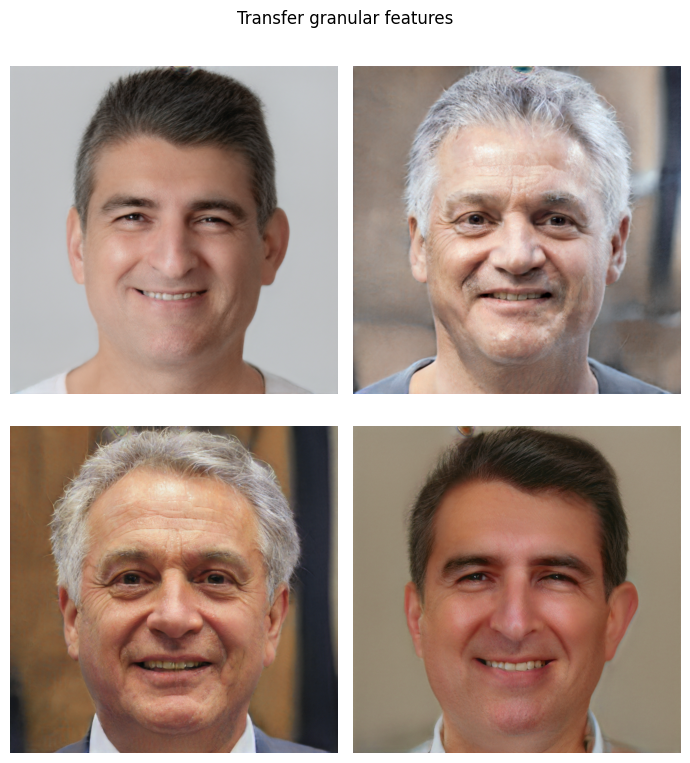

In [15]:
# Perform feature transfer (Style transfer) for slice(4, 15) granular features
idxs_to_swap = slice(4, 15)
my_latents = torch.Tensor(np.load('pred_dlatents_my_image.npy', allow_pickle=True))

A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))
generated_image_latents = trunc(mapper(rand_latents))

x = my_latents.clone()
x[:, idxs_to_swap] = generated_image_latents[:, idxs_to_swap]
a = latent2image(x.float().cuda())

x = generated_image_latents.clone()
x[:, idxs_to_swap] = my_latents[:, idxs_to_swap]
b = latent2image(x.float().cuda())

subplots([A, a, B, b], figsize=(7, 8), nc=2, suptitle='Transfer granular features')

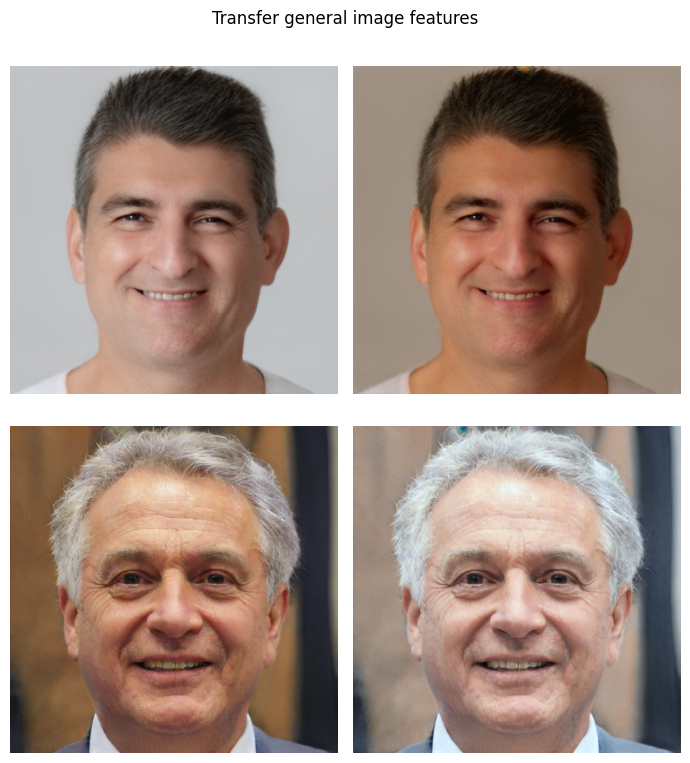

In [16]:
# Perform feature transfer (Style transfer) for slice(16, 18) general image features
idxs_to_swap = slice(16, 18)
my_latents = torch.Tensor(np.load('pred_dlatents_my_image.npy', allow_pickle=True))

A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))
generated_image_latents = trunc(mapper(rand_latents))

x = my_latents.clone()
x[:, idxs_to_swap] = generated_image_latents[:, idxs_to_swap]
a = latent2image(x.float().cuda())

x = generated_image_latents.clone()
x[:, idxs_to_swap] = my_latents[:, idxs_to_swap]
b = latent2image(x.float().cuda())

subplots([A, a, B, b], figsize=(7, 8), nc=2, suptitle='Transfer general image features')

[2024-04-10 21:44:48,419][INFO] Initializing generator.
[2024-04-10 21:44:48,681][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2024-04-10 21:44:48,923][INFO] Successfully loaded!
[2024-04-10 21:44:48,923][INFO]   `lod` of the loaded model is 0.0.
[2024-04-10 21:44:49,082][INFO] Preparing boundary.
[2024-04-10 21:44:49,083][INFO] Preparing latent codes.
[2024-04-10 21:44:49,083][INFO]   Load latent codes from `pred_dlatents_my_image.npy`.
[2024-04-10 21:44:49,084][INFO] Editing 1 samples.
[2024-04-10 21:44:51,588][INFO] Successfully edited 1 samples.


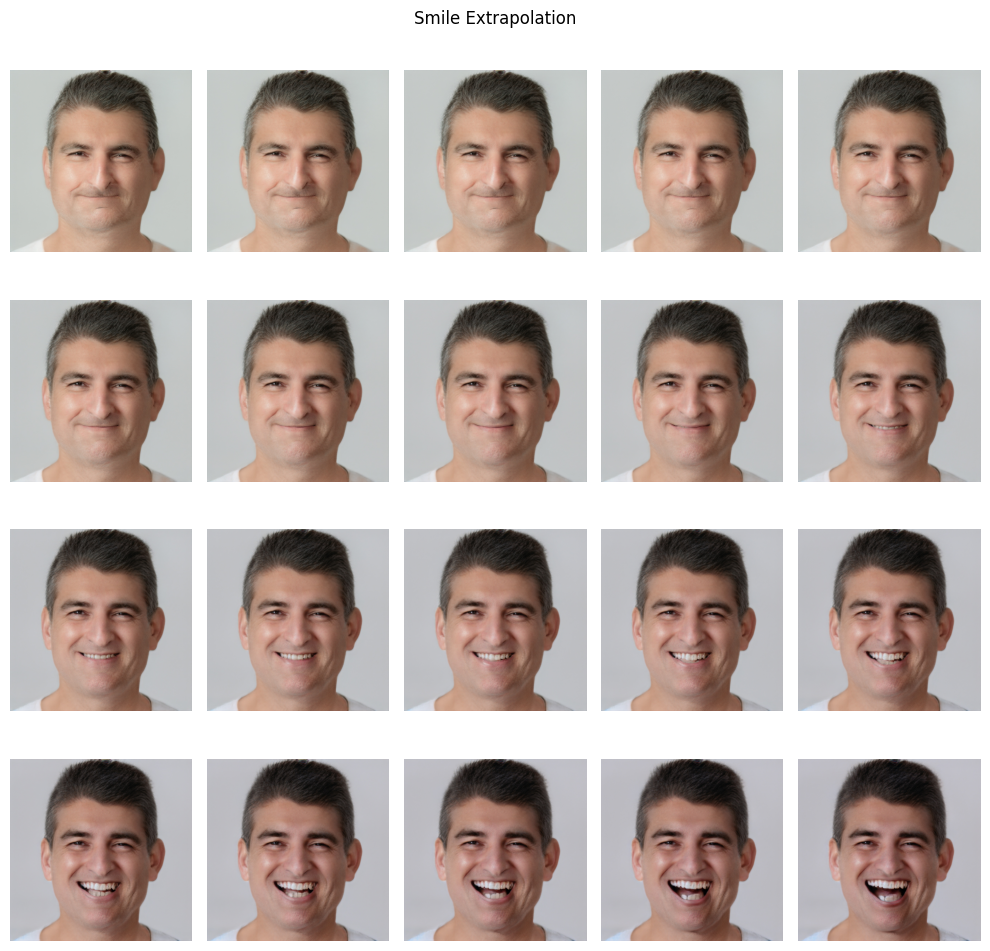

In [17]:
# Extrapolate the smile feature (Edit an image's features using the InterFaceGAN methodology)
!python InterFaceGAN/edit.py\
    -m stylegan_ffhq\
    -o results_new_smile\
    -b InterFaceGAN/boundaries/stylegan_ffhq_smile_w_boundary.npy\
    -i pred_dlatents_my_image.npy\
    -s WP\
    --steps 20
# -m specifies the model to use, here StyleGAN trained on the FFHQ dataset for high-quality human faces
# -o defines the output directory for the manipulated images
# -b points to the boundary file that defines the direction in latent space associated with the smile feature
# -i is the input file containing the latent vector of the image to be edited
# -s sets the semantic direction to WP (W+ space), a specific latent space in StyleGAN known for fine-grained attribute manipulation
# --steps 20 dictates how many steps to take along the boundary direction, generating 20 images with varying intensities of the smile

# Get the paths to all images generated in 'results_new_smile', each representing a different intensity of the smile feature.
generated_faces = glob.glob('results_new_smile/*.jpg')

# Display the generated images in a subplot to visualize the progression of the smile extrapolation
subplots([read(face, 1) for face in sorted(generated_faces)], figsize=(10, 10), suptitle='Smile Extrapolation')